# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24, 48, 72]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 72]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
    f.write(f"RANDOM_STATE: {RANDOM_STATE}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_08-11_46_19


# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(92966, 8)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,28.361905,63.188095,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,28.320588,63.773529,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,28.336667,64.205000,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,28.305000,64.735000,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,28.300000,65.188333,211
...,...,...,...,...,...,...,...,...
92961,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,27.690000,67.290000,216
92962,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,27.401667,68.026667,216
92963,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,27.603333,66.965000,216
92964,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,27.036667,63.361667,216


In [3]:
df_all.isnull().sum()

date                        0
NO2_quantrac            43684
PM25_quantrac           43043
O3_quantrac             47797
CO_quantrac             43760
Temperature_quantrac    52890
Humid_quantrac          52890
station_id                  0
dtype: int64

# Data preparation

## Drop missing

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,28.361905,63.188095,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,28.320588,63.773529,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,28.336667,64.205000,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,28.305000,64.735000,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,28.300000,65.188333,211
...,...,...,...,...,...,...,...,...
38704,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,27.690000,67.290000,216
38705,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,27.401667,68.026667,216
38706,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,27.603333,66.965000,216
38707,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,27.036667,63.361667,216


## Visualization (before converting)

In [10]:
def plot_feature(df, target_col="NO2_quantrac", station_id=211):
    plt.figure(figsize=(13, 4))
    plt.plot(df["date"], df[target_col], label=target_col, linewidth=1.5)
    plt.title(f"Station {station_id} - {target_col}")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for col in df_station.columns:
        if col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_feature(df_station, target_col=col, station_id=station)
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

In [7]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,28.361905,63.188095,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,28.320588,63.773529,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,28.336667,64.205000,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,28.305000,64.735000,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,28.300000,65.188333,211
...,...,...,...,...,...,...,...,...
38704,2022-12-31 19:00:00,166.161013,41.450000,75.916667,2393.562733,27.690000,67.290000,216
38705,2022-12-31 20:00:00,156.713627,50.530000,66.116667,2301.054200,27.401667,68.026667,216
38706,2022-12-31 21:00:00,158.753760,55.055000,55.133333,2773.918067,27.603333,66.965000,216
38707,2022-12-31 22:00:00,125.515280,26.078333,46.750000,1698.984200,27.036667,63.361667,216


## Visualization (after converting)

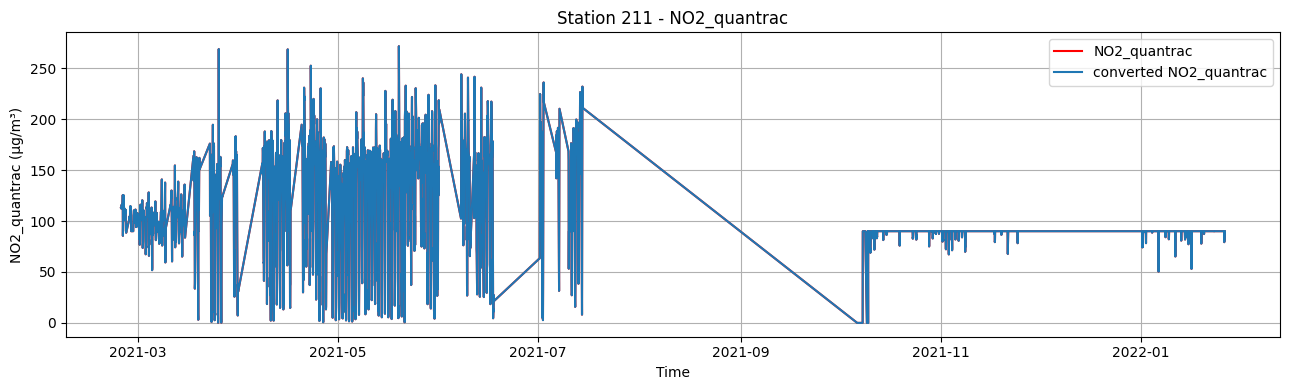

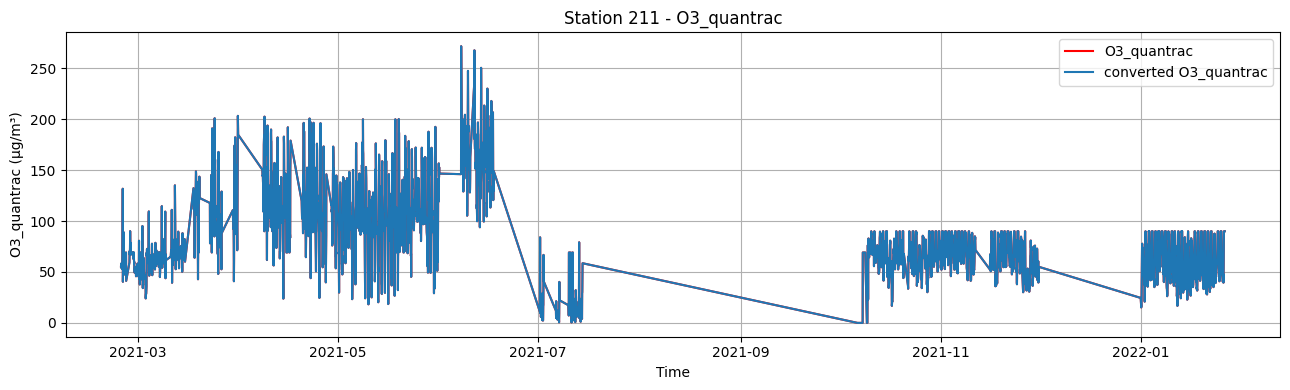

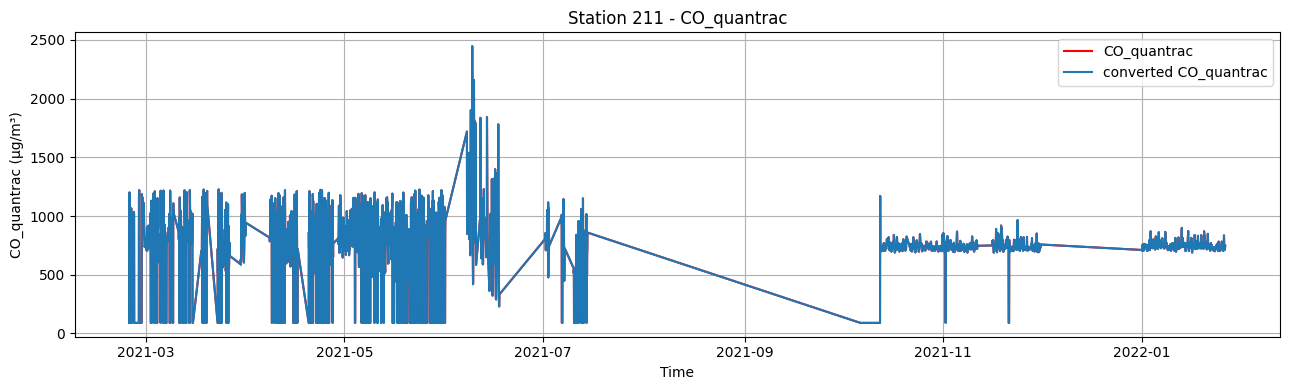

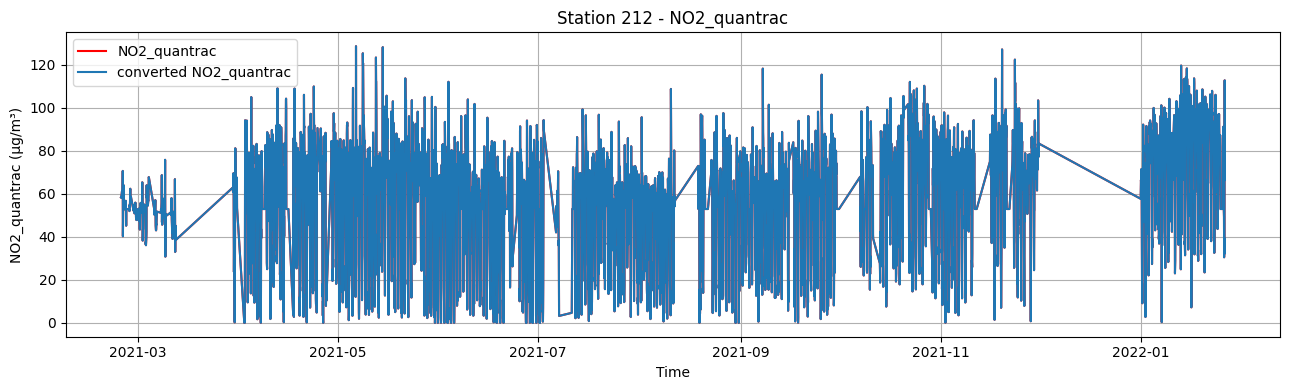

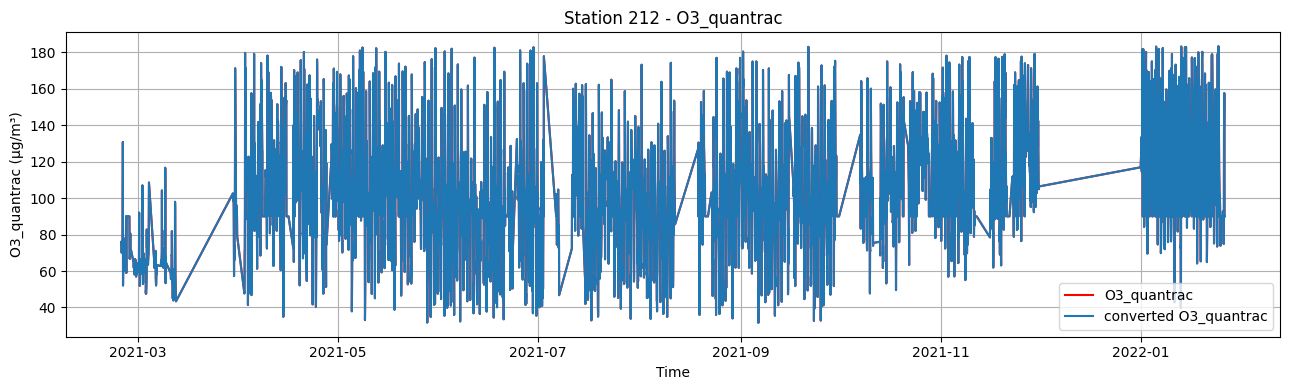

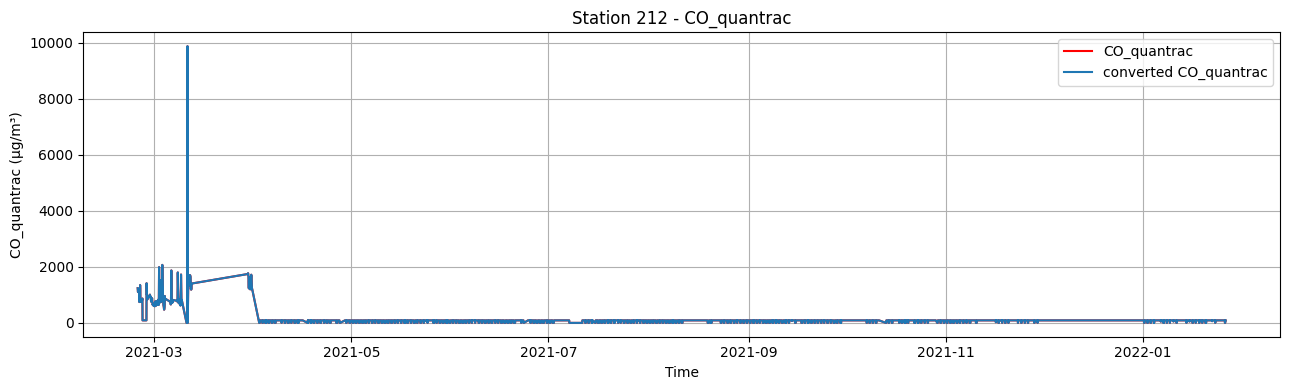

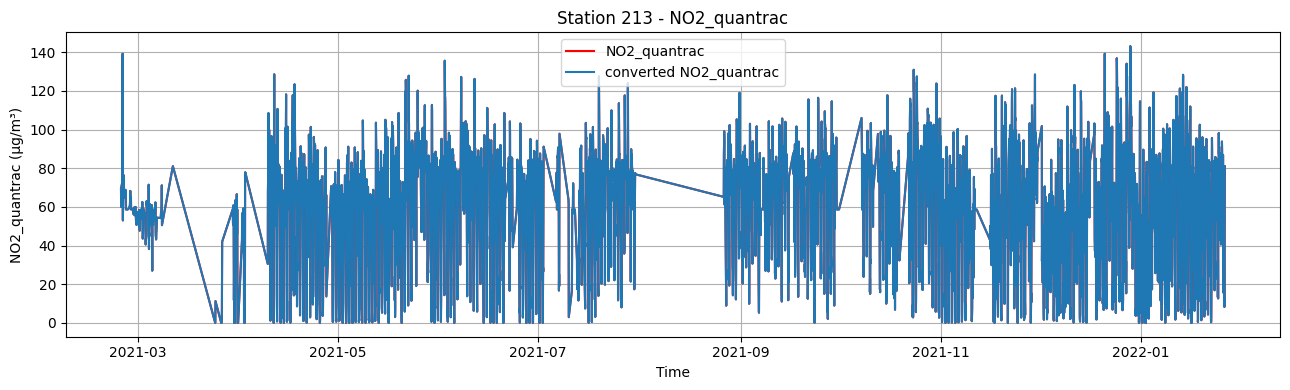

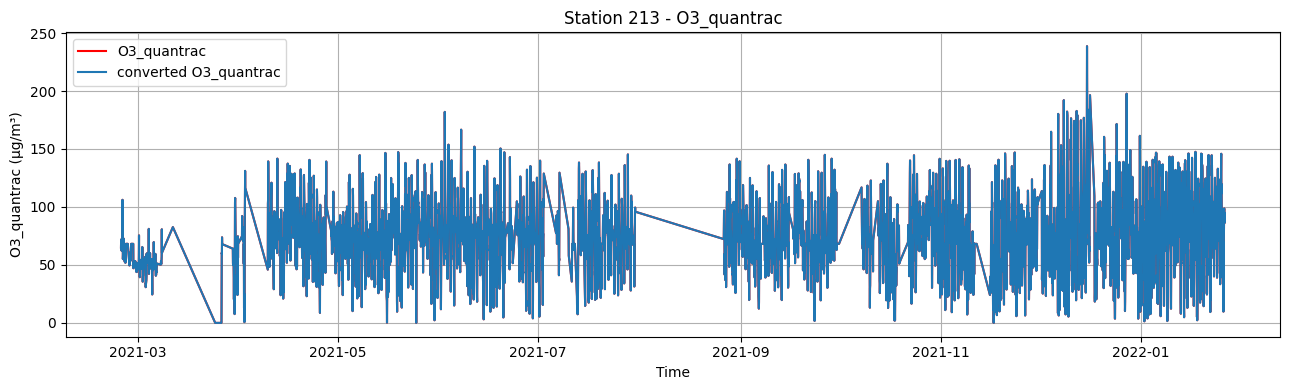

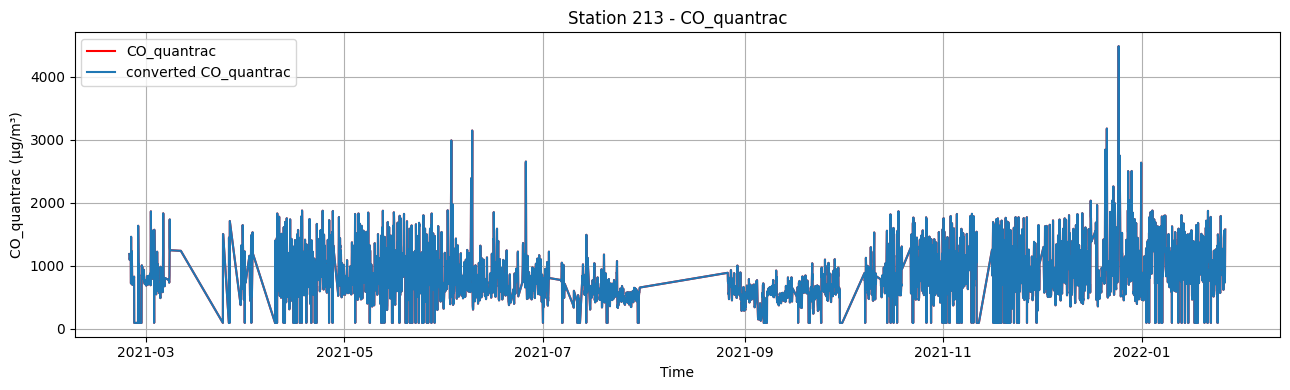

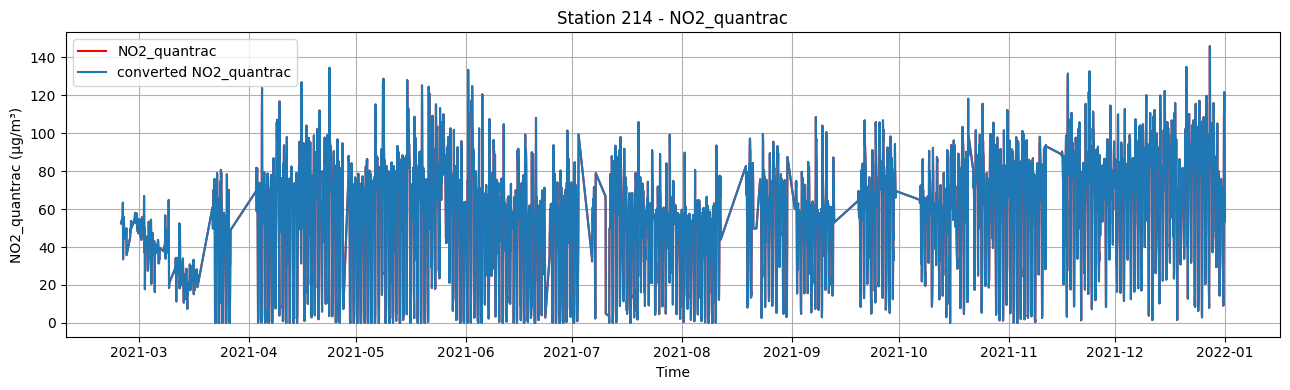

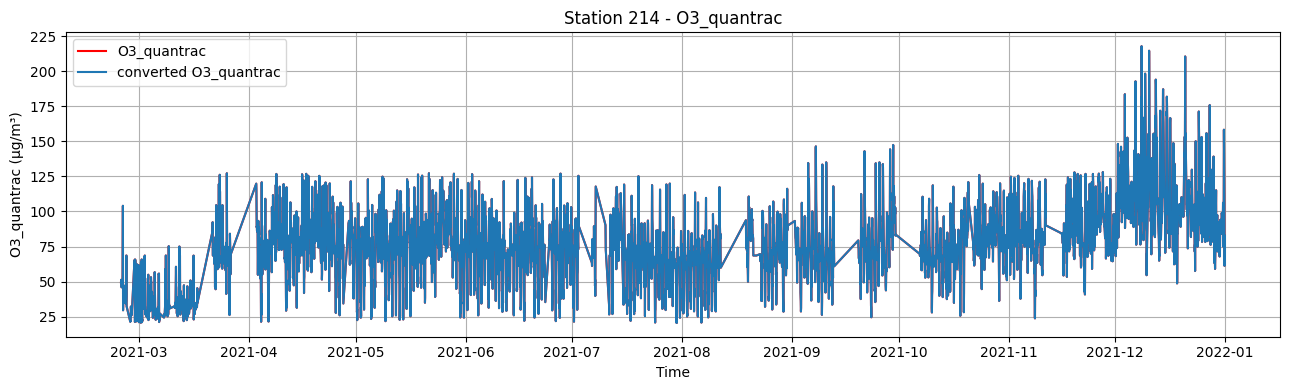

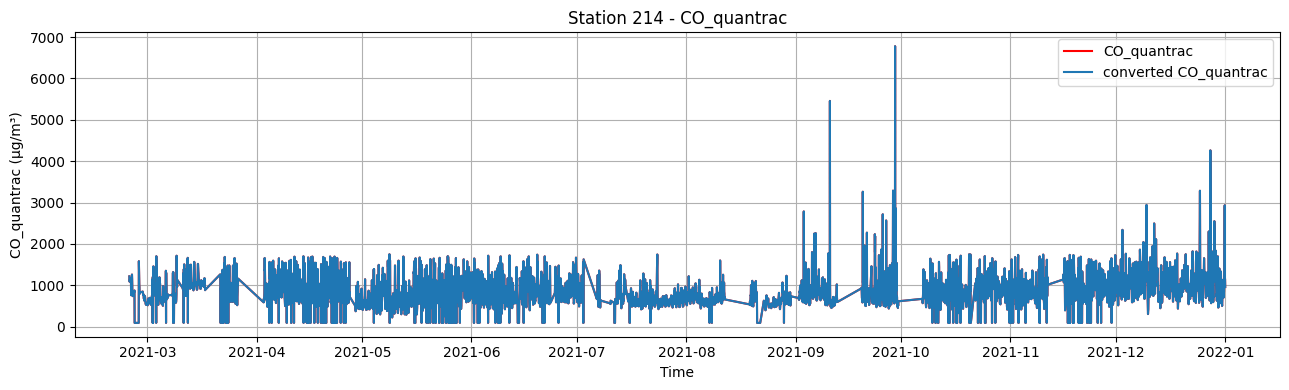

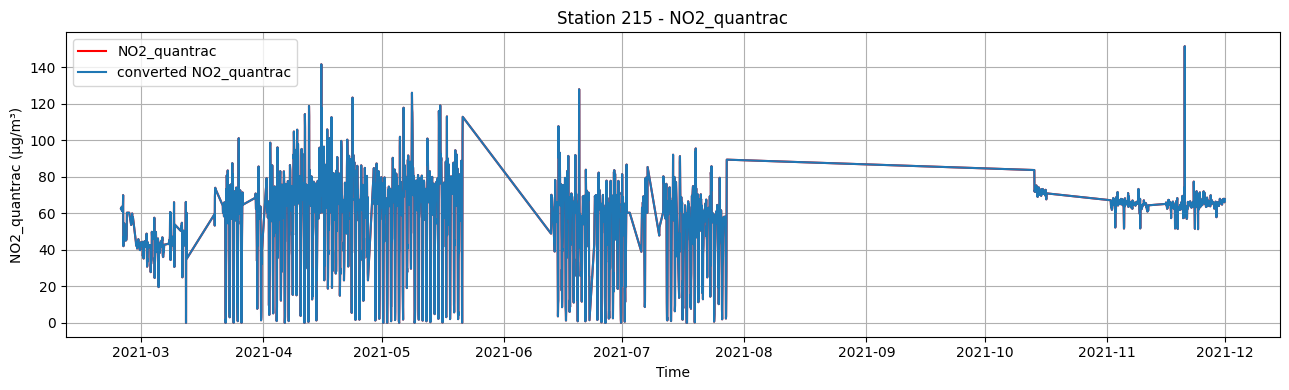

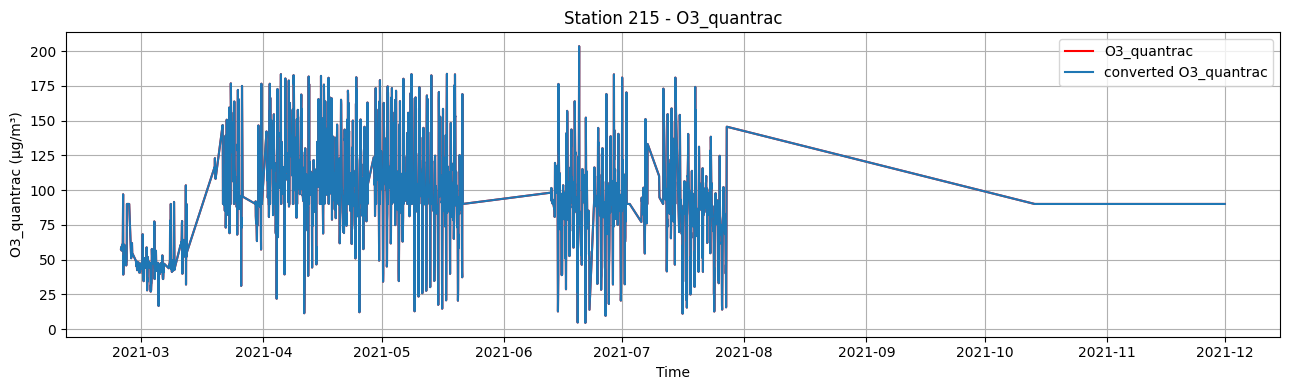

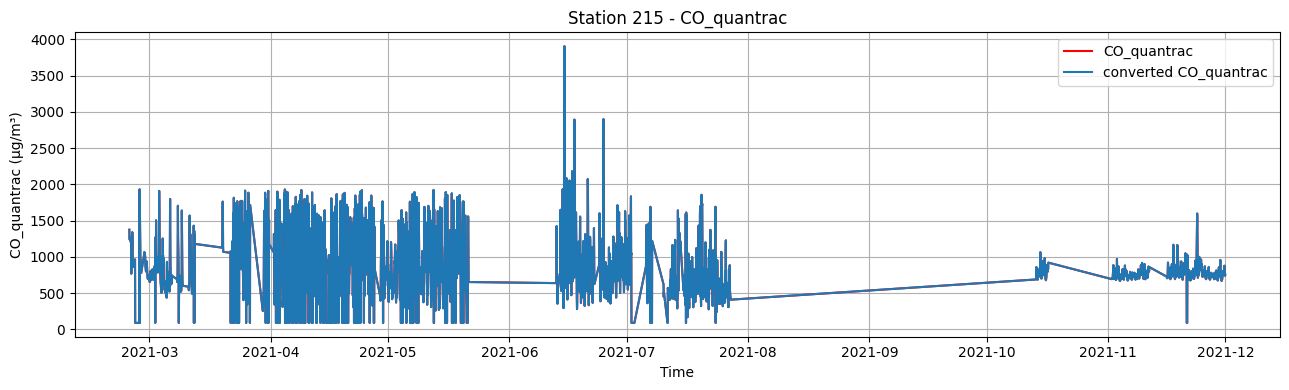

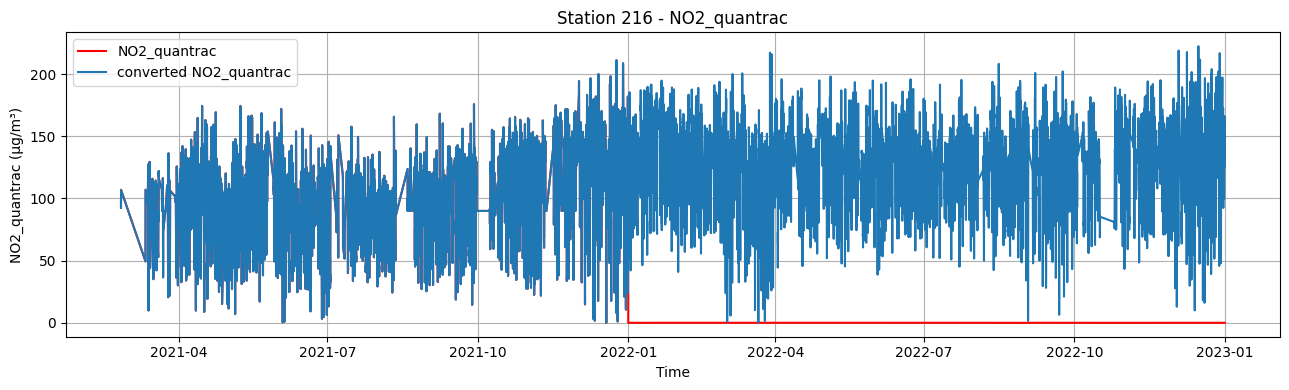

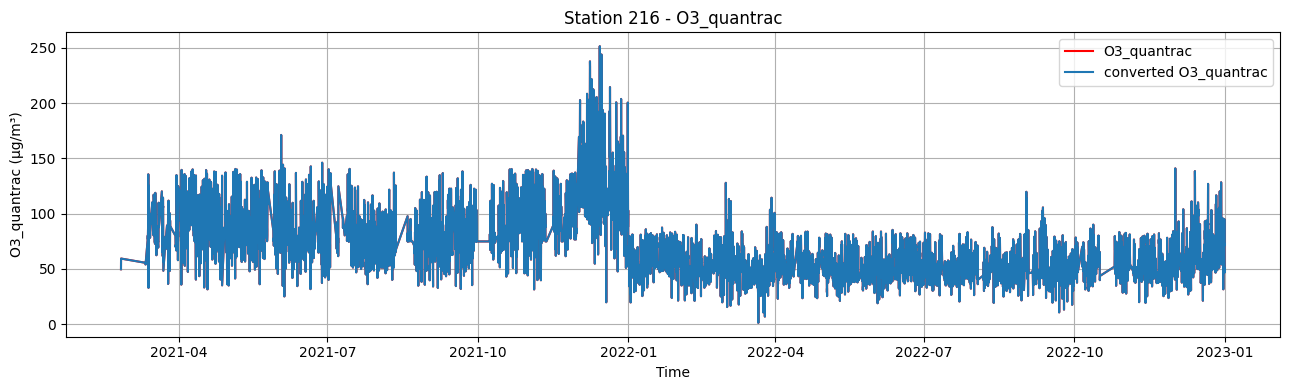

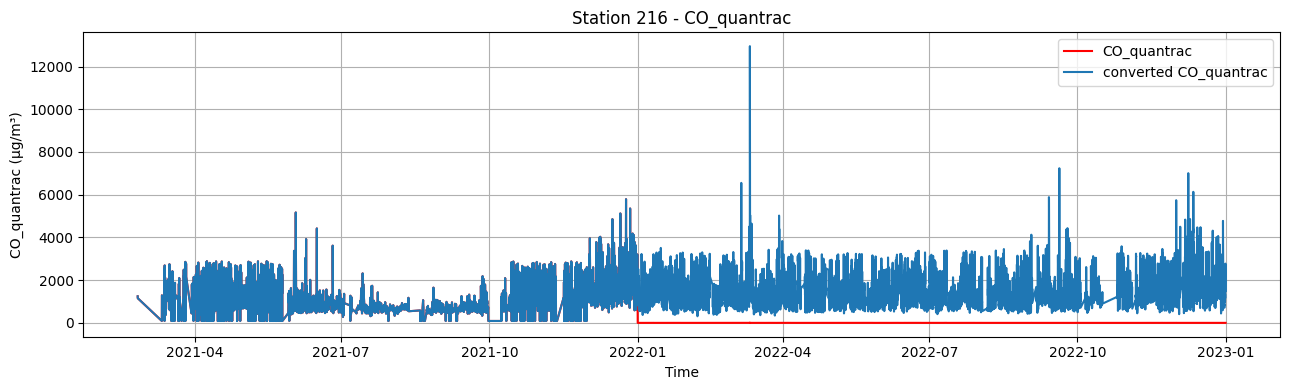

In [15]:
def plot_feature_converted(df, df_converted, target_col="NO2_quantrac", station_id=211):
    plt.figure(figsize=(13, 4))
    plt.plot(df["date"], df[target_col], label=target_col, color="r")
    plt.plot(df_converted["date"], df_converted[target_col], label=f"Converted {target_col}")
    plt.title(f"Station {station_id} - {target_col}")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for col in df_station.columns:
        if col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_feature_converted(df_station, df_station_converted, target_col=col, station_id=station)
    print("\n" + "=" * 150 + "\n")

## Feature engineering

In [ ]:
def add_time_features(df, time_col="date"):
    df = df.copy()
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    return df

# Add lag features for all FEATURES including LABEL
def add_lag_features(df, group_col, target_cols, lag_steps):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for lag in lag_steps:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

# Just add the rolling features for LABEL
def add_rolling_features(df, group_col, target_cols, windows):
    assert isinstance(target_cols, list), "target_cols should be a list"

    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = (
                df.groupby(group_col)[col]
                  .shift(1) # use the past, avoid leaking
                  .rolling(window=w, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )
            df[f"{col}_roll{w}_std"] = (
                df.groupby(group_col)[col]
                  .shift(1)
                  .rolling(window=w, min_periods=1)
                  .std()
                  .reset_index(level=0, drop=True)
            )
    return df

# Add time features and lag feature for all gases
df_all = add_time_features(df_all)
df_all = add_lag_features(df_all, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

# Example to add rolling features with no2 gases
dftestno2 = add_rolling_features(df_all, group_col="station_id", target_cols=["NO2_quantrac"], windows=ROLL_WINDOWS)
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

## Build supervised from time-series

In [ ]:
# Reframe past future
def build_supervised_for_horizon(df, horizon_h, target_col):
    # Sort data by station_id then date
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    # Define target_name, which is the target_col plus horizon_h hour
    target_name = f"{target_col}_t_plus_{horizon_h}h"
    df[target_name] = df.groupby("station_id")[target_col].shift(-horizon_h)

    # Dropna after shifting
    df = df.dropna().reset_index(drop=True)

    # Define label, feature and meta columns
    label_cols = [target_name]
    meta_cols = ["date", "station_id"]
    feature_cols = [c for c in df.columns if c not in label_cols + meta_cols + [target_col]]

    # Get the X, y and meta data
    X = df[meta_cols + feature_cols]
    y = df[meta_cols + label_cols]

    return X, y

# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=1, target_col="NO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

## Split train/validation/test for each station

In [ ]:
def train_test_validation_split(X, y, train_ratio=0.7, val_ratio=0.15):
    assert (X["date"].equals(y["date"]) and X["station_id"].equals(y["station_id"])), "X and y should have the same metadata values"

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    meta_train, meta_val, meta_test = [], [], []

    meta_cols = ["date", "station_id"]
    
    for station in list(sorted(X["station_id"].unique())):
        X_station = X[X["station_id"] == station]
        y_station = y[y["station_id"] == station]
        meta = X_station[meta_cols]

        X_station = X_station.drop(columns=meta_cols)
        y_station = y_station.drop(columns=meta_cols)
    
        n = len(X_station)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
    
        X_train.append(X_station.iloc[:train_end])
        y_train.append(y_station.iloc[:train_end])
        meta_train.append(meta.iloc[:train_end])
    
        X_val.append(X_station.iloc[train_end:val_end])
        y_val.append(y_station.iloc[train_end:val_end])
        meta_val.append(meta.iloc[train_end:val_end])
    
        X_test.append(X_station.iloc[val_end:])
        y_test.append(y_station.iloc[val_end:])
        meta_test.append(meta.iloc[val_end:])

    X_train = pd.concat(X_train, axis=0)
    X_val = pd.concat(X_val, axis=0)
    X_test = pd.concat(X_test, axis=0)
    
    y_train = pd.concat(y_train, axis=0)
    y_val = pd.concat(y_val, axis=0)
    y_test = pd.concat(y_test, axis=0)
    
    meta_train = pd.concat(meta_train, axis=0)
    meta_val = pd.concat(meta_val, axis=0)
    meta_test = pd.concat(meta_test, axis=0)

    return (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test)

# Example
(X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test) = train_test_validation_split(Xdummy, ydummy)
display(X_test)

## Metrics

In [ ]:
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Bias Error
    mbe = np.mean(y_pred - y_true)

    # MNBE
    yt_nonzero = np.where(y_true == 0, np.nan, y_true)
    mnbe = np.nanmean((y_pred - yt_nonzero) / yt_nonzero) * 100.0

    # Pearson r (with standard deviation check)
    if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
        r = np.nan
    else:
        r = np.corrcoef(y_true.T, y_pred.T)[0, 1]

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MBE": mbe,
        "MNBE": mnbe,
        "r": r,
        "n_samples": len(y_true),
    }

# LightGBM model

## Training

In [ ]:
def train_lgbm_for_horizon(df_feat,
                           horizon_h,
                           target_col,
                           learning_rate=0.05,
                           n_estimators=2000,
                           early_stopping_rounds=100):

    # Build supervised dataset
    X, y = build_supervised_for_horizon(df_feat, horizon_h=horizon_h, target_col=target_col)

    # Split train validation test
    (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Dataset cho LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": learning_rate,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "device": "cuda",
        "seed": RANDOM_STATE,
    }

    # Early stopping dùng callback (tương thích nhiều version LightGBM)
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100),
    ]
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "val"],
        callbacks=callbacks,
    )

    # Prediction
    y_pred = np.expand_dims(model.predict(X_test, num_iteration=model.best_iteration), axis=-1)
    metrics_overall = compute_metrics(y_test, y_pred)

    # Metrics for each station
    df_test_res = meta_test.copy()
    df_test_res["y_true"] = y_test.values
    df_test_res["y_pred"] = y_pred

    rows = []
    for sid, grp in df_test_res.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
    metrics_by_station = pd.DataFrame(rows)

    return model, metrics_overall, metrics_by_station, (
        X_train, y_train, X_val, y_val, X_test, y_test, meta_test
    )

## Reference

In [ ]:
def plot_timeseries_example(df, model, horizon_h, station_id, target_col, n_points=300):
    # Prepare data for reference
    X, y = build_supervised_for_horizon(df, horizon_h, target_col)
    (_, _, _,
     _, _, _,
     X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Get the data of station
    mask = (meta_test["station_id"] == station_id)
    X_test_sid = X_test[mask]
    y_test_sid = y_test[mask]
    meta_sid = meta_test[mask]
    if len(X_test_sid) == 0:
        print(f"No test sample for station {station_id}")
        return
    
    # Prediction
    y_pred_sid = model.predict(X_test_sid, num_iteration=getattr(model, "best_iteration", None))

    # Plotting
    X_plot = meta_sid.iloc[-n_points:]
    y_true_plot = y_test_sid.iloc[-n_points:]
    y_pred_plot = y_pred_sid[-n_points:]

    plt.figure(figsize=(14, 5))
    plt.plot(X_plot["date"], y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    plt.plot(X_plot["date"], y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    plt.title(f"Station {station_id} - Horizon {horizon_h}h")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHTGBM_DIR, f"{target_col}_lightgbm_{horizon_h}h_{station_id}_{n_points}.png"))
    plt.show()

## Training for NO2

In [ ]:
label = "NO2_quantrac"

# Add rolling features for LABEL
df_no2 = add_rolling_features(df_all, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_no2.columns)

# Start running model
no2_all_metrics = []
no2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_no2, horizon_h=h, target_col=label)
    no2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    no2_all_metrics.append(metrics_by_station)

# Metrics table
no2_df_metrics_all = pd.concat(no2_all_metrics, ignore_index=True)
no2_df_metrics_all = no2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
no2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
no2_df_metrics_all

In [ ]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_no2, no2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label)

## Training for O3

In [ ]:
label = "O3_quantrac"

# Add rolling features for LABEL
df_o3 = add_rolling_features(df_all, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_o3.columns)

# Start running model
o3_all_metrics = []
o3_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_o3, horizon_h=h, target_col=label)
    o3_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    o3_all_metrics.append(metrics_by_station)

o3_df_metrics_all = pd.concat(o3_all_metrics, ignore_index=True)
o3_df_metrics_all = o3_df_metrics_all.sort_values(["station", "horizon_h"])
o3_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
o3_df_metrics_all

In [ ]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in [1, 24, 48, 72]:
        print(f"hour = {hour}")
        plot_timeseries_example(df_o3, o3_models_by_h[hour], horizon_h=hour, station_id=int(station_id), target_col=label)

## Training for CO

In [ ]:
label = "CO_quantrac"

# Add rolling features for LABEL
df_co = add_rolling_features(df_all, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_co.columns)

# Start running model
co_all_metrics = []
co_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_co, horizon_h=h, target_col=label)
    co_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    co_all_metrics.append(metrics_by_station)

co_df_metrics_all = pd.concat(co_all_metrics, ignore_index=True)
co_df_metrics_all = co_df_metrics_all.sort_values(["station", "horizon_h"])
co_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
co_df_metrics_all

In [ ]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in [1, 24, 48, 72]:
        print(f"hour = {hour}")
        plot_timeseries_example(df_co, co_models_by_h[hour], horizon_h=hour, station_id=int(station_id), target_col=label)